In [106]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import string
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import torch.nn.functional as F

import torchvision.transforms as transforms

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [108]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.characters = string.ascii_letters
        self.nchar = len(self.characters)+1
        self.data = os.listdir(data_dir)
        self.max_length = 12

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        pic = self.data[idx]
        img_path = os.path.join(self.data_dir, pic)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img = self.transform(img)

        pic_target = pic[:-5]
        target = np.zeros((self.max_length, self.nchar), dtype=np.float32)
        
        for j, char in enumerate(pic_target[:self.max_length]):
            index = self.characters.find(char)
            target[j, index+1] = 1

        color_label = 1 if pic[-5] == "1" else 0

        return img, target, color_label

19999 29999
torch.Size([3, 128, 128])
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

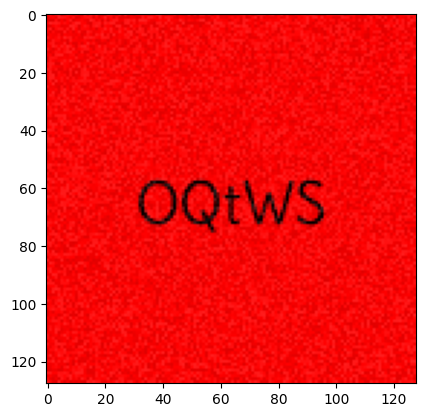

In [109]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),  
])

dataset = CustomDataset("dataset", transform=transform)
sampleset = CustomDataset("samples", transform=transform)

train_size = int(0.4 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
sample_loader = DataLoader(sampleset, batch_size=1, shuffle=False, pin_memory=True)

print(len(train_dataset), len(test_dataset))

for img,label,color in test_dataset:
    print(img.shape)
    print(label)
    print(color)
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    break

In [110]:
class MyNN(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((32, 12))

        self.rnn = nn.RNN(input_size=64*32, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128,53)

        self.bg_classifier = nn.Linear(64*32*12, 2)

    def forward(self, x):
        
        batch_size = x.size(0)
        
        conv_output = self.features(x)
        conv_output = self.adaptive_pool(conv_output)
        
        conv_output = conv_output.permute(0, 3, 1, 2)
        sequence_length = conv_output.size(1)
        conv_output = conv_output.reshape(batch_size, sequence_length, -1)

        rnn_output, final_output = self.rnn(conv_output)
        logits = self.fc(rnn_output)

        bg_logits = self.bg_classifier(conv_output.reshape(batch_size, -1))

        return F.log_softmax(logits, dim=2), bg_logits

In [111]:
epochs = 20
learning_rate = 0.001
model = MyNN()
model = model.to(device)

char_loss_fn = nn.CTCLoss(blank=0, reduction='mean',zero_infinity=True)
color_loss_fn = nn.CrossEntropyLoss()

lambda_char = 1
lambda_bg = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [112]:
for epoch in range(epochs):
    model.train()

    total_loss = 0
    total_char_loss = 0
    total_bg_loss = 0

    for images, targets,color in train_loader:

        images = images.to(device)
        targets = targets.to(device)
        color = color.to(device)

        batch_size = images.size(0)

        optimizer.zero_grad()

        log_probs, bg_logits = model(images)  
        log_probs = log_probs.permute(1, 0, 2)
        
        input_lengths = torch.full((batch_size,), log_probs.size(0), dtype=torch.long, device=device)
        targets_indices = targets.argmax(dim=2)
        target_lengths = [int((t > 0).sum().item()) for t in targets_indices]
        
        flat_targets = torch.cat([t[t > 0] for t in targets_indices])
        
        char_loss = char_loss_fn(log_probs, flat_targets, input_lengths, torch.tensor(target_lengths, dtype=torch.long, device=device))
        bg_loss = color_loss_fn(bg_logits, color)
        
        loss = lambda_char * char_loss + lambda_bg * bg_loss

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_char_loss += char_loss.item()
        total_bg_loss += bg_loss.item()

    avg_loss = total_loss / len(train_loader)
    avg_char_loss = total_char_loss / len(train_loader)
    avg_bg_loss = total_bg_loss / len(train_loader)

    print(f"Epoch {epoch+1}: Total Loss: {avg_loss}, Char Loss: {avg_char_loss}, BG Loss: {avg_bg_loss}")


Epoch 1: Total Loss: 3.0745398553848267, Char Loss: 3.0743271667480467, BG Loss: 0.0021268984106064446
Epoch 2: Total Loss: 0.489099374127388, Char Loss: 0.4890806530714035, BG Loss: 0.0001872150934722992
Epoch 3: Total Loss: 0.35319428578615186, Char Loss: 0.35319036351442334, BG Loss: 3.92243297621178e-05
Epoch 4: Total Loss: 0.3121021887898445, Char Loss: 0.31208958448171614, BG Loss: 0.00012604735820304392
Epoch 5: Total Loss: 0.29097256079912187, Char Loss: 0.2906727933049202, BG Loss: 0.002997674754874221
Epoch 6: Total Loss: 0.2688226111292839, Char Loss: 0.26880555421113966, BG Loss: 0.0001705692286910061
Epoch 7: Total Loss: 0.258481366866827, Char Loss: 0.258431491035223, BG Loss: 0.0004987581440626421
Epoch 8: Total Loss: 0.2471664597272873, Char Loss: 0.24716537342071535, BG Loss: 1.086300414323631e-05
Epoch 9: Total Loss: 0.23469114659428597, Char Loss: 0.23469101006388665, BG Loss: 1.3659103281824514e-06
Epoch 10: Total Loss: 0.2274085950255394, Char Loss: 0.2274085950255

In [113]:
def clean_predictions(predictions):
    non_blank_predictions = predictions[predictions != 0]

    cleaned_predictions = []
    i = 0
    while i < len(non_blank_predictions):
        count = 1
        while i + 1 < len(non_blank_predictions) and non_blank_predictions[i] == non_blank_predictions[i + 1]:
            count += 1
            i += 1

        merged_count = (count // 2) + (count % 2)
        cleaned_predictions.extend([non_blank_predictions[i]] * merged_count)

        i += 1

    cleaned_predictions += [0] * (12 - len(cleaned_predictions))
    return torch.tensor(cleaned_predictions)

In [119]:
model.eval()

total_captchas = 0
correct_captchas = 0
total_characters = 0
correct_characters = 0
correct_bg_color = 0

with torch.no_grad():
    for batch_features, batch_labels, color in test_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        color = color.to(device)
        
        outputs,bg_logits = model(batch_features)

        predictions = torch.argmax(outputs, dim=2)
        target_indices = torch.argmax(batch_labels, dim=2)
        
        valid_char_mask = batch_labels.sum(dim=2) != 0

        cleaned_predictions = predictions.clone()
        for i in range(predictions.size(0)):
            cleaned_predictions[i] = clean_predictions(predictions[i])

        _, bg_predictions = torch.max(bg_logits, dim=1)

        total_captchas += target_indices.size(0)
        correct_per_sequence = ((cleaned_predictions == target_indices) | ~valid_char_mask).all(dim=1)
        correct_captchas += correct_per_sequence.sum().item()

        correct_bg_color += (bg_predictions == color).sum().item()

        total_characters += valid_char_mask.sum().item()
        correct_characters += ((cleaned_predictions == target_indices) & valid_char_mask).sum().item()

captcha_accuracy = 100 * correct_captchas / total_captchas
character_accuracy = 100 * correct_characters / total_characters
bg_accuracy = 100 * correct_bg_color / total_captchas

print(f"Captcha Accuracy: {captcha_accuracy:.2f}%")
print(f"Character Accuracy: {character_accuracy:.2f}%")
print(f"Background Color Accuracy: {bg_accuracy:.2f}%")

Captcha Accuracy: 79.00%
Character Accuracy: 88.05%
Background Color Accuracy: 100.00%


In [115]:
character = [
    '','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z',  'A', 'B', 'C', 'D',
    'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
    'Y', 'Z','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z',  'A', 'B', 'C', 'D',
    'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
    'Y', 'Z'
]

def findWord(k_ind, color):
    k_ind = k_ind.tolist()
    captcha = ''.join([character[k] for k in k_ind])

    if(color == 1):
        captcha = captcha[::-1]
    
    return captcha

In [116]:
with torch.no_grad():
    for batch_features, batch_labels, color in test_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        color = color.to(device)
        
        outputs,bg_logits = model(batch_features)
        predictions = torch.argmax(outputs, dim=2)
        _, bg_predictions = torch.max(bg_logits, dim=1)
        
        for i in range(batch_features.size(0)):
            print(findWord(clean_predictions(predictions[i]),bg_predictions[i].item()),findWord(batch_labels[i].argmax(dim=1),bg_predictions[i].item()))

SWtQO SWtQO
IDiJsg IDiJsg
kNbIY kNbIY
yASJs yASSJs
JzuWGdG JzuWGdG
MWxWw MWxWw
SyMGjI SyMGjI
oHObvN oHObvN
cJgRr cJJgRr
jaVw jaVVw
POYFotq POYFotq
HBNbQGf HBNbQGf
cZVrMwf cZVrMwf
tJdNmB tJdNmB
cZCdMYs cZCdMYs
gAWPK gAWPK
GGMqr GGMqr
owIFPY owIFPY
oREMC oREMC
YkcPdz YkcPdz
KdOyG KdOyG
jGSkdX jGSkdX
MKLoe MKLoe
EvofY EvofY
VdlRuq VdlRuq
dypqvea dypqvea
lFMSa lFMSa
rAfE rbAfE
gfARI gfARI
ZCsXzJt ZCsXzJt
kvEJVFW kvEJVFW
xikfF xiikftF
BHIICN BHIaICN
grTzAJd grTzAJd
pCyimZN pCyimZN
oYcwzP oYcwzP
qPbtnwK qPbtnwK
uclBdM uclBdM
mlDMXx mlDMXx
NAkBl NAkBrl
lmRnSTL lmRnSTL
azUHvN azUHvN
BhdPmB BhdPmB
evVMSg evVMSg
IZoUqzw IZoUqzw
YYIXmMS YYIXmMS
MeEtF MeEtF
gAlX gAllX
ncHNjP hcxHNjP
cqEjT cqEjT
nXiqukB nXiqukB
UtsVsb UtsVsb
mCEeWo mCEeWo
iyvVTaH iyvVTaH
IpKRag IpKRag
fWCuYQ fWCuYQ
QJaxt QJaxt
QXOlPsT QXOlPsT
tkxr tkxfr
fZmkI ffZmkI
pBkErAl pBkErAl
InynPFW InynPFW
QARw QAvRw
ejnIUnZ ejnIUnZ
JdAEsI JdAEsI
icQFj icQFj
gNWmfs gNWmfs
yjkMfJy yjkMfJy
VAXzOdX VAXzOdX
NCgzYN NCgzYN
ibkgaj ibkgaj
ThxqikF T

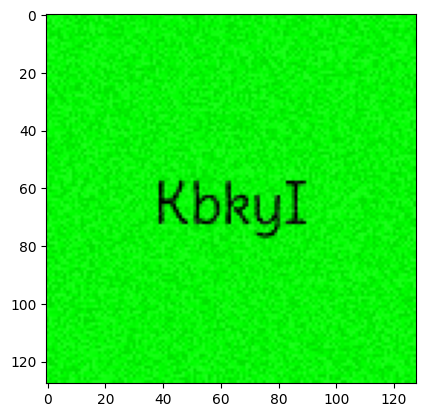

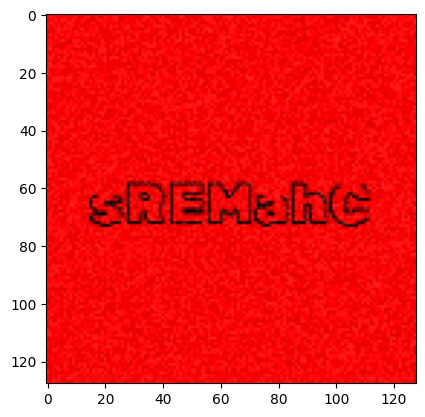

In [117]:
for img,label,color in sampleset:
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

In [118]:
with torch.no_grad():
    for batch_features, batch_labels, color in sample_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        color = color.to(device)
        
        outputs,bg_logits = model(batch_features)
        predictions = torch.argmax(outputs, dim=2)
        _, bg_predictions = torch.max(bg_logits, dim=1)
        
        for i in range(batch_features.size(0)):
            print(findWord(clean_predictions(predictions[i]),bg_predictions[i].item()))

KbkyI
ChaMERs
